# 39AA Project Part 3
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/glaframb71/CS39AA-Project/blob/main/39aa-project-part-2.ipynb)

<font size='3'>Welcome to the third and final part of my 39AA Project! In the last two parts, we imported a data set of NFL players from the 2022 season that included their 'nflId', 'height', 'weight', 'birthDate', 'collegeName', 'position', and 'displayName'. With that data set, I decided I wanted to try and train some models to predict and athletes NFL position based of their 'height', 'weight', and 'collegeName'. Exploratory Data Analysis was then performed to get a visual representation of the data we had to work with and to better understand the structure of the set. We then moved on to train a RandomForestClassifier ML model with the data to see how well it would perform. In Part 3, we will be doing similar work that was done in Part 2 but this time we will be attempting to train an exisiting deep learning model. Let's go ahead and get started shall we?</font>

<font size='3'>Let's start by importing the neccesary libraries that are needed to complete this task.</font>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

<font size='3'>Now let's import our dataset.</font>

In [2]:
playersDataUrl = "https://raw.githubusercontent.com/glaframb71/CS39AA-Project/main/data/players.csv"
playersData = pd.read_csv(playersDataUrl)

playersData.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


<font size='3'>The dataset has been successfully imported! Let's clean it up and filter out the players we had filtered out in Part 2.</font>

In [3]:
playersData = playersData.copy()
playersData.loc[:, 'height_inches'] = playersData['height'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))
height_index = playersData.columns.get_loc('height')
playersData.insert(height_index + 1, "height_inches", playersData.pop("height_inches"))
players = playersData[['height_inches', 'weight','collegeName', 'position']]

positions_to_drop = ['DB', 'LS']
filtered_players = players[~players['position'].isin(positions_to_drop)]

filtered_players.head()

,height_inches,weight,collegeName,position
0,76,225,Michigan,QB
1,76,328,Arkansas,T
2,74,225,California,QB
3,78,267,UCLA,TE
4,76,217,Boston College,QB


<font size='3'>Now let's label encode our positions for when we take a look at the predicitons made by the model.</font>

In [4]:
positions = filtered_players['position'].values
label_encoder = LabelEncoder()
label_encoder.fit(positions)
encoded_positions = label_encoder.transform(positions)

<font size='3'>We have our cleaned up set with the collumns 'height_inches', 'weight', 'collegeName', and 'position' that represent NFL players. Now lets split this set up into our X and y data set and train a neural network. To do this I'm going to use a Sequential model with a few hidden layers using RELU as our activation function.</font>

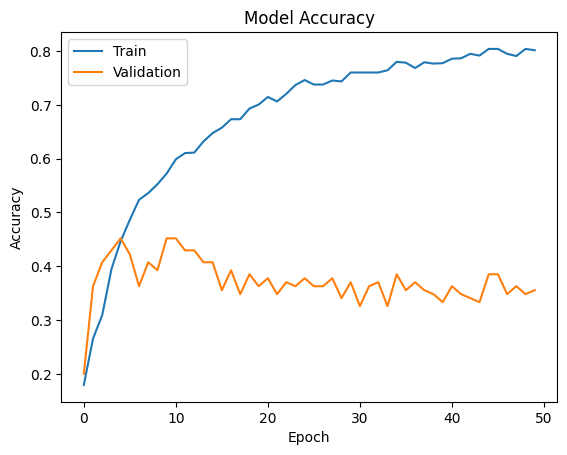

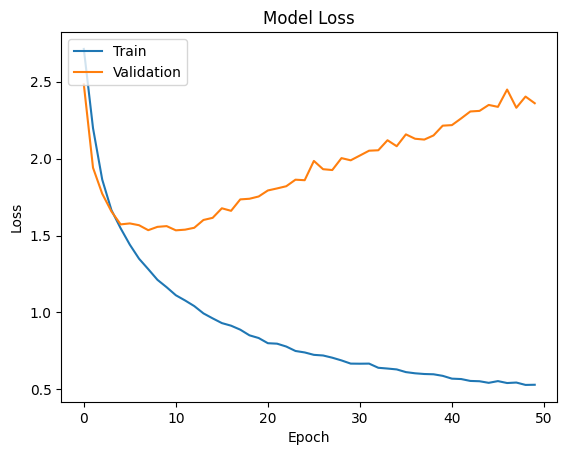

In [5]:
X = filtered_players[['height_inches', 'weight', 'collegeName']]
y = filtered_players['position']

column_transformer = ColumnTransformer([
    ('num', StandardScaler(), ['height_inches', 'weight']),
    ('cat', OneHotEncoder(sparse_output=False), ['collegeName'])  # Use sparse_output=False
], remainder='passthrough')

X = column_transformer.fit_transform(X)
y = OneHotEncoder(sparse_output=False).fit_transform(y.to_frame())  # Use sparse_output=False

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

initalModel = Sequential()
initalModel.add(Dense(128, input_dim=227, activation='relu'))
initalModel.add(Dense(64, activation='relu'))
initalModel.add(Dense(32, activation='relu'))
initalModel.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

initalModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = initalModel.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


<font size='3'>Unfortunately, our initial model ended up overfitting, just like our RandomForestClassifier model did in Part 2. Let's try using GridSearchCV again to test different combinations of hyperparameters along with implementing Dropout and Early Stopping to see if we can reduce the overfitting.</font>

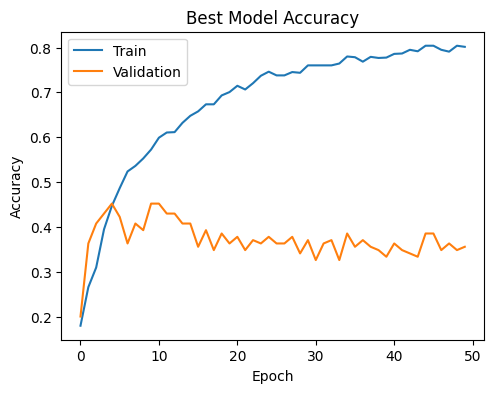

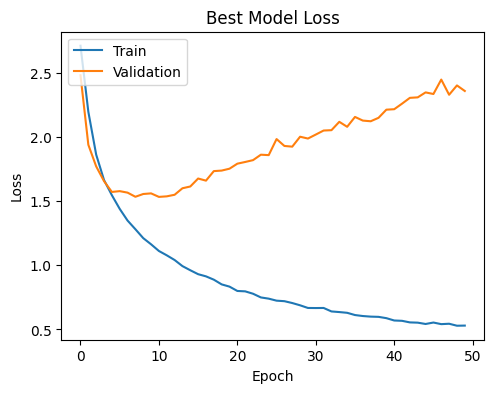

Best score: 0.42729970812797546
Best hyperparameters: {'batch_size': 32, 'epochs': 25, 'optimizer': 'rmsprop', 'activation': 'relu'}


In [6]:
batch_sizes = [32, 64, 128]
epochs = [25, 35, 50]
optimizers = ['adam', 'rmsprop']
activations = ['relu', 'tanh']

def create_compile_model(optimizer, activation, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=227, activation=activation))
    model.add(Dropout(0.5))  # Add dropout with a 50% drop probability
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.5))  # Add another dropout layer
    model.add(Dense(32, activation=activation))
    model.add(Dropout(0.5))  # And another one
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

best_score = 0
best_params = {}

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True
)

for batch_size in batch_sizes:
    for epoch in epochs:
        for optimizer in optimizers:
            for activation in activations:

                model = create_compile_model(optimizer, activation, y_train.shape[1])

                tuneHistory = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)

                loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        'batch_size': batch_size,
                        'epochs': epoch,
                        'optimizer': optimizer,
                        'activation': activation
                    }
                    best_history = history

if best_history:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'])
    plt.plot(best_history.history['val_accuracy'])
    plt.title(f'Best Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title(f'Best Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

print(f"Best score: {best_score}")
print(f"Best hyperparameters: {best_params}")


<font size='3'>After attempting to use GridSearchCV and techniques such as Dropout and Early Stopping, our model is still overfitting the data. I am assuming that the dataset size has something to do with why we are overfitting so badly. Perhaps there are too many colleges that are taking into account. Anyways let's see the predictions that the model made with the best hyperparameters found.</font>

In [7]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    filtered_players[['height_inches', 'weight', 'collegeName']], 
    filtered_players['position'], 
    test_size=0.2, 
    random_state=42
)

predictions = initalModel.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
predicted_positions = label_encoder.inverse_transform(predicted_labels)

for i in range(len(X_test_orig)):
    height = X_test_orig.iloc[i]['height_inches']
    weight = X_test_orig.iloc[i]['weight']
    college = X_test_orig.iloc[i]['collegeName']
    prediction = predicted_positions[i]
    print(f"Sample {i}: Height - {height} inches, Weight - {weight} lbs, College - {college}, Predicted position - {prediction}")


11/11 [==============================] - 0s 2ms/step
Sample 0: Height - 73 inches, Weight - 196 lbs, College - Oklahoma, Predicted position - WR
Sample 1: Height - 72 inches, Weight - 202 lbs, College - Alabama, Predicted position - SS
Sample 2: Height - 77 inches, Weight - 310 lbs, College - Texas A&amp;M, Predicted position - T
Sample 3: Height - 76 inches, Weight - 310 lbs, College - Mississippi State, Predicted position - DT
Sample 4: Height - 77 inches, Weight - 288 lbs, College - North Carolina, Predicted position - OLB
Sample 5: Height - 75 inches, Weight - 316 lbs, College - Iowa, Predicted position - C
Sample 6: Height - 76 inches, Weight - 245 lbs, College - Indiana, Predicted position - TE
Sample 7: Height - 75 inches, Weight - 213 lbs, College - Syracuse, Predicted position - QB
Sample 8: Height - 75 inches, Weight - 242 lbs, College - Penn State, Predicted position - ILB
Sample 9: Height - 76 inches, Weight - 280 lbs, College - Notre Dame, Predicted position - C
Sample 10: